In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from talib import abstract
import math

## This is to Convert a string representation of list into list 
import ast

from functools import partial

In [2]:
mydict={}
with open('DataLoader/nifty_3min.txt', 'r') as file:
    data = file.read().rstrip()
    data=ast.literal_eval(data)

    
dfo=pd.DataFrame(data,columns =['Date','Open','High','Low','Close','Volume','NA'])
dfo['Date']=dfo['Date'].astype('datetime64[ns]')
dfo['Date']=dfo['Date'].dt.tz_localize("GMT").dt.tz_convert('Asia/Kolkata')
dfo.set_index('Date',inplace=True)

In [125]:
dfo

,Open,High,Low,Close,Volume,NA
Date,,,,,,
2022-01-25 09:15:00+05:30,17001.55,17001.55,16868.95,16877.90,0,0
2022-01-25 09:18:00+05:30,16875.35,16891.55,16837.85,16890.35,0,0
2022-01-25 09:21:00+05:30,16890.40,16956.40,16882.15,16956.40,0,0
2022-01-25 09:24:00+05:30,16958.20,16981.40,16946.20,16979.70,0,0
2022-01-25 09:27:00+05:30,16981.60,17006.55,16955.40,16978.70,0,0
...,...,...,...,...,...,...
2022-02-24 15:15:00+05:30,16275.65,16278.35,16232.75,16235.05,0,0
2022-02-24 15:18:00+05:30,16234.15,16246.20,16215.00,16226.55,0,0
2022-02-24 15:21:00+05:30,16227.35,16233.40,16218.15,16221.50,0,0


In [4]:
def pxline(to_plot):
    fig = px.line(to_plot)
    fig.show()

In [127]:
def madisparity(df,ma):
    df['MA']=df['Close'].rolling(ma).mean()
    df.dropna(inplace=True)
    df['disparity']=df['Close']/df['MA']-1
    return df

In [203]:
df=madisparity(df,5)

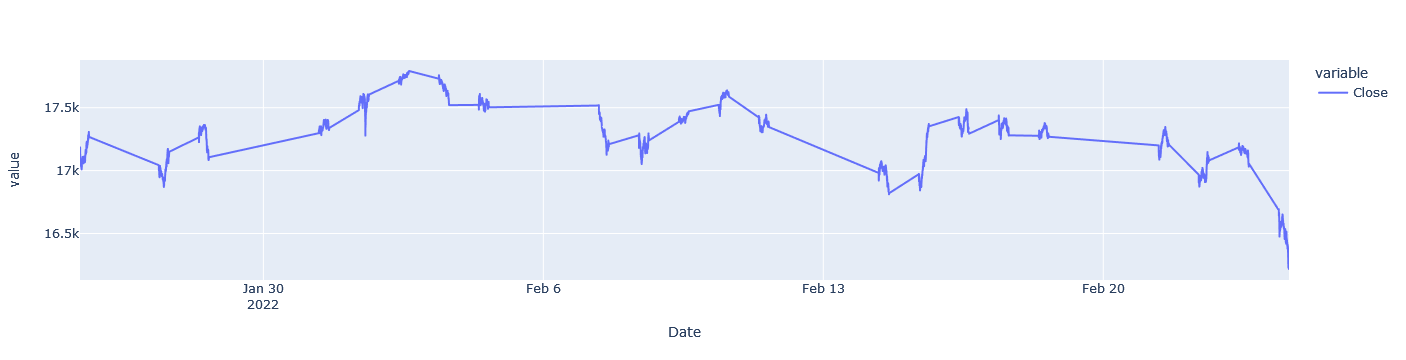

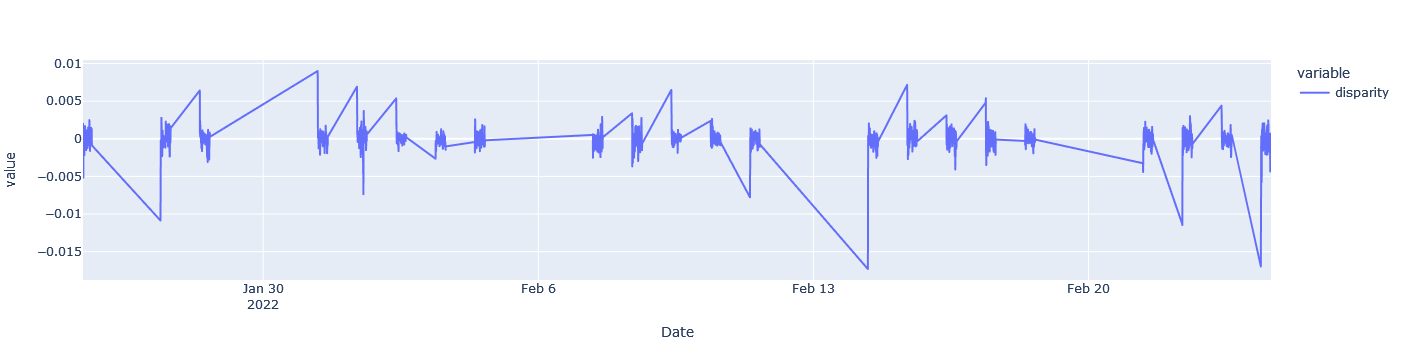

In [205]:
pxline(df.Close)
pxline(df.disparity)

In [169]:
def backtest(df):

    Resutls=pd.DataFrame(df.index).assign(ACash=0,Trade_Count=0,PositionDays=0,BuyPrice=0,ABuyPrice=0,SellPrice=0,CurrentPrice=0,Quantity=0,DailyPNL=0,DailyPerChange=0.0)
    Resutls.set_index('Date',inplace=True)
    Resutls.iloc[0,0]=100000
    pos=0
    days_in_pos=0
    buy_price=0
    sell_price=0
    trade_results=[]
    for i in df.index:
        if i != df.index[0]:
            sell= ((df['pos'][i]== 11) and (df['pos'].shift(1)[i]==1)) or ((df['pos'][i]== 11) and (df['pos'].shift(1)[i]==0))
            buy= ((df['pos'][i]== 0) and (df['pos'].shift(1)[i]==1)) or ((df['pos'][i]== 0) and (df['pos'].shift(1)[i]==11))


            if sell: # Sell Triggred
                if pos==0:
                    pos=1
                    current_price=df['Close'][i]
                    sell_price=current_price
                    Resutls.at[i,'Trade_Count']=1
                    print(f'Sell Triggred,Selling at {current_price} on {i}')

                else : # Already in Sell Position Increase the number of days in trade and note today's % Change
                    days_in_pos+=1
                    current_price=df['Close'][i]
                    Resutls.at[i,'Trade_Count']=1
                    Resutls.at[i,'PositionDays']=days_in_pos

                    Today_Change=(df['P_Daily_Change'][i])*(-1)
                    Resutls.at[i,'DailyPerChange']=Today_Change
                    # print(f' Sell Triggred but Aready in Sell trade on {i}')

            elif buy: # long covering Triggred Close the Position 
                if pos==1:                    
                    pos=0
                    current_price=df['Close'][i]
                    buy_price=current_price
                    Resutls.at[i,'Trade_Count']=0
                    days_in_pos=0
                    print(f'Buy Triggred,Buying at {current_price} on {i}')
                    gl=((sell_price/buy_price)-1)
                    trade_results.append(gl)
                else: ## Sell Triggred but not in buy postion at this moment so do nothing 
                    # print(f' Buy Triggred but no trade is ON  on {i}')
                    pass

            else :#or sell: ##No Buy or Sell Triggred but trade could be already in Place
                if pos==1: # Buy Trade is active ,Increase the number of days in trade and note today's % Change
                    days_in_pos+=1
                    current_price=df['Close'][i]
                    Resutls.at[i,'Trade_Count']=1
                    Resutls.at[i,'PositionDays']=days_in_pos

                    Today_Change=(df['P_Daily_Change'][i])*(-1)
                    Resutls.at[i,'DailyPerChange']=Today_Change
                    # print(f' Continue -Aready in Sell trade on {i}')
                else: # Not in trade to Do nothing 
                    # print(f' Nothing Triggred and no trade is ON  on {i}')
                    # print(f"Current Close{df['Close'][i]} and Last Low to Corss {df['High'].shift(1)[i]}")
                    pass
    return Resutls,trade_results


In [16]:
def matrix(trade_result):
    matrixList=[]
    gains=0
    ng=0
    losses=0
    nl=0
    for i in trade_result:
        if(i>0):
            gains+=i
            ng+=1
        else:
            losses+=i
            nl+=1

    if(ng>0):
        avgGain=gains/ng
        maxR=max(trade_result)
    else:
        avgGain=0
        maxR=0

    if(nl>0):
        avgLoss=losses/nl
        maxL=min(trade_result)
        ratio=-avgGain/avgLoss
    else:
        avgLoss=0
        maxL=0
        ratio=999

    if(ng>0 or nl>0):
        battingAvg=(ng/(ng+nl))*100
    else:
        battingAvg=0
    #### Calculate Concurrent Loss and Gain 
    gainlist=[]
    losslist=[]
    npg=0
    npl=0
    for i in trade_result:
        if i!=trade_result[-1]:
            if i>0:
                losslist.append(npl)
                npg+=1
                npl=0
            elif i<0:
                gainlist.append(npg)
                npl+=1
                npg=0
        else:
            if i>0:
                npg+=1
            if i<0:
                npl+=1
            losslist.append(npl)
            gainlist.append(npg)
    
    total=ng+nl
    winavg=battingAvg
    profit_loss_ratio=ratio
    maxprofit=max(trade_result)*100
    maxloss=min(trade_result)*100
    avggain_trade=avgGain*100
    avgloss_trade=avgLoss*100
    max_gain_streak=max(gainlist)
    max_loss_streak=max(losslist)
    matrixList.extend([total,ng,nl,winavg,profit_loss_ratio,maxprofit,maxloss,avggain_trade,avgloss_trade,max_gain_streak,max_loss_streak])
    
    return matrixList
    
    # print(f'Total Trades : {ng+nl}')
    # print(f'Number of Winners: {ng} and Number of Loss Trades : {nl}')
    # print(f'Win Average: {round(battingAvg,2)}%')
    # print(f'Profil/Loss Ratio : {round(ratio,2)}')
    # print(f'maximum % Profit in one trade : {round(max(trade_result)*100,2)}%')
    # print(f'maximum % Loss in one trade : {round(min(trade_result)*100,2)}%')
    # print(f'Averge gain per Trade: {round(avgGain,2)}')
    # print(f'Averge loss per Trade: {round(avgLoss,2)}')


In [8]:
# #Download Data from yahoo
# ### TEST Scnarios - TCS- Bull ,ACC- modrate up (Sidewase),YESBank- Back to Zero ,ITC(stock dosnt even Move)
# def getdata(asset,start,end):
#     stock=asset
#     indexes=['^NSEI']
#     if stock not in indexes:
#         startdate=start
#         # enddate='2020-01-01'
#         enddate=end
#         exchange=['.NS','.BO']
#         dfo = yf.download(stock+exchange[0],start=startdate,end=enddate)
#     else:

#         startdate=start
#         # enddate='2020-01-01'
#         enddate=end
#         dfo = yf.download(stock,start=startdate,end=enddate)
#     return dfo

In [199]:
##[pos]-->11 buy
##[pos]-->1 Continue
##[pos]-->0 Sell
def conditions(df):
    
    # & (df['Close']>df['Close'].shift(1).rolling(5).mean())
    df['In']=np.where((df['Close'].shift(1)<df['Low'].shift(3)) & ((df.disparity>0.004)|(df.disparity < -0.001)), 1,0)
    df['Out']=np.where((df['Close']>df['Close'].shift(1).rolling(4).max()),0,1)




    for i in df.index:
        df.at[i,'pos']=str(df['In'][i])+str(df['Out'][i])
    df['pos']=df['pos'].astype(str).astype(int)
    return df

In [10]:
# dfo=getdata(asset='ACC',start='2007-01-01',end='2022-01-01')



In [200]:
matrixdf=pd.DataFrame(index=['total_trades','gain_count','loss_count','winavg','profit_loss_ratio','maxprofit',
                                                    'maxloss','avggain_trade','avgloss_trade','max_win_streek','max_loss_streek','StratergyReturns','UnderLineReturns'])
    
df=dfo.copy()
df=madisparity(df,10)
df['P_Daily_Change']=df['Close'].pct_change()
df.dropna(inplace=True)
df=conditions(df)
result_df,trade_results=backtest(df)
matrixList=matrix(trade_results)

result_df['CReturns']=(((1+result_df['DailyPerChange']).cumprod()-1)*100)
df['CReturns']=(((1+df['P_Daily_Change']).cumprod()-1)*100)
df['S_DailyChange']=result_df['DailyPerChange']
df['S_CReturns']=result_df['CReturns']
S_CReturns=result_df[-1:]['CReturns'][0]
U_CReturns=df[-1:]['CReturns'][0]

matrixList.extend([S_CReturns,U_CReturns])
matrixdf[f'Nifty']=matrixList

Sell Triggred,Selling at 17111.3 on 2022-01-25 10:06:00+05:30
Buy Triggred,Buying at 17083.1 on 2022-01-25 10:36:00+05:30
Sell Triggred,Selling at 17020.35 on 2022-01-25 10:48:00+05:30
Buy Triggred,Buying at 17028.5 on 2022-01-25 11:00:00+05:30
Sell Triggred,Selling at 17064.65 on 2022-01-25 11:57:00+05:30
Buy Triggred,Buying at 17076.85 on 2022-01-25 12:06:00+05:30
Sell Triggred,Selling at 17070.85 on 2022-01-25 12:48:00+05:30
Buy Triggred,Buying at 17078.8 on 2022-01-25 13:00:00+05:30
Sell Triggred,Selling at 17181.9 on 2022-01-25 14:15:00+05:30
Buy Triggred,Buying at 17219.15 on 2022-01-25 14:18:00+05:30
Sell Triggred,Selling at 17042.85 on 2022-01-27 09:15:00+05:30
Buy Triggred,Buying at 16981.4 on 2022-01-27 09:48:00+05:30
Sell Triggred,Selling at 16961.4 on 2022-01-27 10:21:00+05:30
Buy Triggred,Buying at 16995.2 on 2022-01-27 10:33:00+05:30
Sell Triggred,Selling at 16960.25 on 2022-01-27 10:54:00+05:30
Buy Triggred,Buying at 16971.7 on 2022-01-27 11:12:00+05:30
Sell Triggred,Sel

In [201]:
matrixdf.T

,total_trades,gain_count,loss_count,winavg,profit_loss_ratio,maxprofit,maxloss,avggain_trade,avgloss_trade,max_win_streek,max_loss_streek,StratergyReturns,UnderLineReturns
Nifty,94.0,37.0,57.0,39.361702,2.695118,2.12791,-0.969351,0.318206,-0.118067,5.0,6.0,16.19118,-5.231403


In [99]:
result_df

,ACash,Trade_Count,PositionDays,BuyPrice,ABuyPrice,SellPrice,CurrentPrice,Quantity,DailyPNL,DailyPerChange,CReturns
Date,,,,,,,,,,,
2022-01-25 09:18:00+05:30,100000,0,0,0,0,0,0,0,0,0.000000,0.000000
2022-01-25 09:21:00+05:30,0,0,0,0,0,0,0,0,0,0.000000,0.000000
2022-01-25 09:24:00+05:30,0,0,0,0,0,0,0,0,0,0.000000,0.000000
2022-01-25 09:27:00+05:30,0,0,0,0,0,0,0,0,0,0.000000,0.000000
2022-01-25 09:30:00+05:30,0,0,0,0,0,0,0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24 15:15:00+05:30,0,1,26,0,0,0,0,0,0,0.002338,17.106752
2022-02-24 15:18:00+05:30,0,1,27,0,0,0,0,0,0,0.000524,17.168064
2022-02-24 15:21:00+05:30,0,1,28,0,0,0,0,0,0,0.000311,17.204529


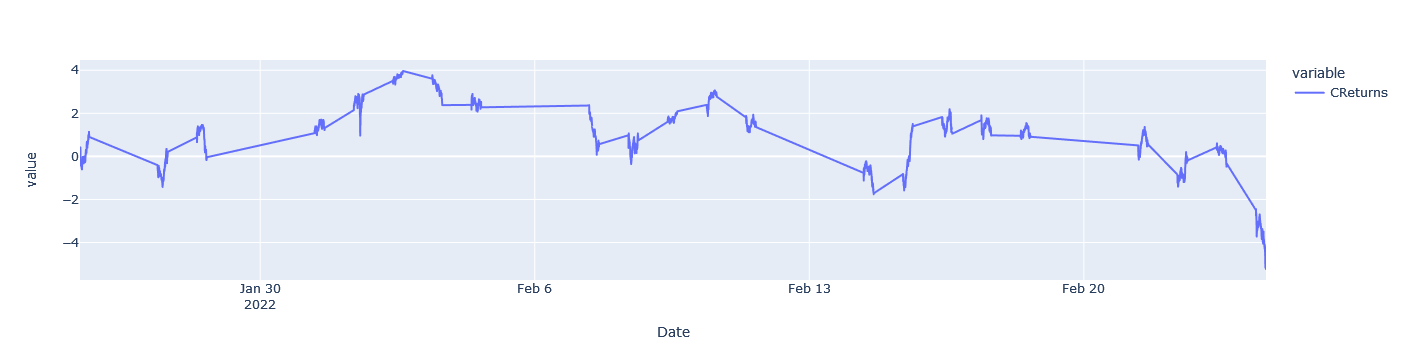

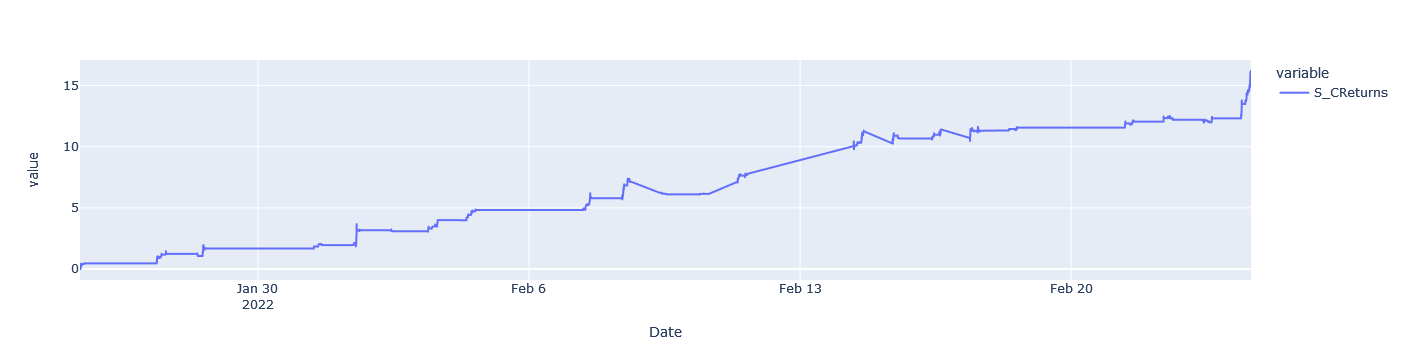

In [202]:
pxline(df['CReturns'])
pxline(df['S_CReturns'])

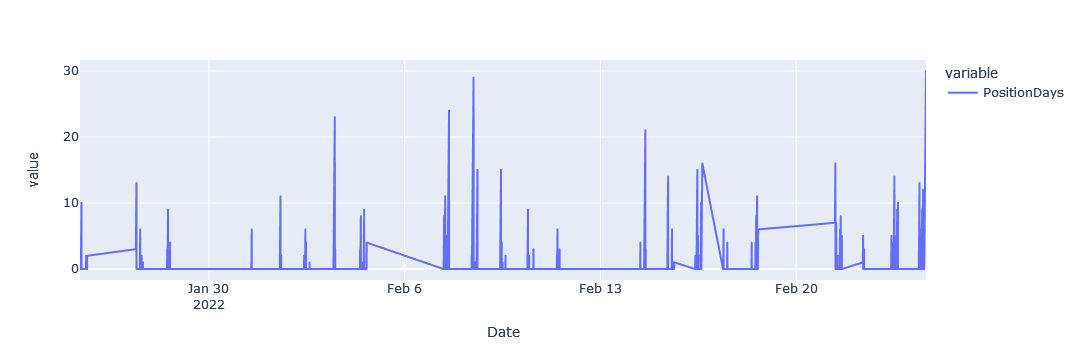

In [101]:
pxline(result_df['PositionDays'])